# 5. Sensitivity Analysis

## 5.1 Define the problem and policies

In [1]:
# Imports

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, MultiprocessingEvaluator, perform_experiments, ema_logging, Policy, Scenario)
ema_logging.log_to_stderr(ema_logging.INFO)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties, sample_levers
from ema_workbench.util import ema_logging, save_results, load_results


from SALib.analyze import sobol
from plotting_for_sobol import plot_sobol_indices, plot_scores

import statsmodels.api as sm

C:\Users\frac1\Anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')


In [2]:
# Specification of the problem

from problem_formulation import get_model_for_problem_formulation
dike_model, planning_steps = get_model_for_problem_formulation(8)

## 5.2 Sobol's scores

Since the R squared values obtained from the OLS Regression above are too low, the OLS Regression model is deemed not to be fitting the dike_model well. This may be due to multiple non-linear effects present in the dike_model. To run a sensitivity analysis, a Sobol Analysis is carried out instead.

We will run a sensitivity analysis over a total of N(2K+2) experiments, where K is the number of levers availble in the dike model, and N is the baseline number of experiments

In [4]:
# We set the baseline number of experiments (N) here:
N = 200

# Check the number of levers (K) that the model has:
K = len(dike_model.levers)

# The overall number of experiments that will be run is:
n_exp = N*(2*K+2)

print("The overall number of experiments that will be run for the sensitivity analysis using SOBOL is: ", n_exp)

The overall number of experiments that will be run for the sensitivity analysis using SOBOL is:  12800


We now determine the reference scenario for which the sensitivity analysis over the levers will be performed:

In [6]:
# Load experiment results from a situation in which no action is taken as a policy
[experiments, outcomes] = load_results("../results/Holistic_msMORDM_WorstCaseDeaths_PF8.tar.gz") 
outcomes_df = pd.DataFrame(data=outcomes)

#Get index of worst-case scenario
index_wc = outcomes_df.sort_values("Expected Number of Deaths").tail(1).index
experiment_wc = experiments.iloc[index_wc]

#Set the reference scenario as the worst-case scenario
reference_scenario = [Scenario(f"{index}", **row) for index, row in experiment_wc.iloc[0:,0:19].iterrows()]
reference_scenario

[MainProcess/INFO] results loaded succesfully from C:\Users\frac1\Documents\GitHub\Model Based DM - Assignment collaboration\model-based-decision-making\results\Holistic_msMORDM_WorstCaseDeaths_PF8.tar.gz


[Scenario({'A.0_ID flood wave shape': 67.0, 'A.1_Bmax': 220.6726198643884, 'A.1_Brate': 1.0, 'A.1_pfail': 0.0005403424050262763, 'A.2_Bmax': 126.21875769287712, 'A.2_Brate': 1.5, 'A.2_pfail': 0.1283765046685619, 'A.3_Bmax': 306.8882811206905, 'A.3_Brate': 10, 'A.3_pfail': 0.3887869461381572, 'A.4_Bmax': 345.0324076406681, 'A.4_Brate': 1.0, 'A.4_pfail': 0.2296887322240073, 'A.5_Bmax': 246.71805169242558, 'A.5_Brate': 10.0, 'A.5_pfail': 0.2125545021527128, 'discount rate 0': 3.5, 'discount rate 1': 1.5, 'discount rate 2': 4.5})]

In [7]:
# Execute Sensistivity Analysis over uncertainties
start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
     experiments, outcomes = evaluator.perform_experiments(scenarios = reference_scenario,
                                                           policies = N, 
                                                           levers_sampling = SOBOL)
end = time.time()
print('Sobol time is ' + str(round((end - start)/60)) + ' minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 12800 policies * 1 model(s) = 12800 experiments
[MainProcess/INFO] 1280 cases completed
[MainProcess/INFO] 2560 cases completed
[MainProcess/INFO] 3840 cases completed
[MainProcess/INFO] 5120 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] 7680 cases completed
[MainProcess/INFO] 8960 cases completed
[MainProcess/INFO] 10240 cases completed
[MainProcess/INFO] 11520 cases completed
[MainProcess/INFO] 12800 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Sobol time is 182 minutes


In [8]:
# Save results
results = (experiments, outcomes)
save_results(results,  "../results/Sensitivity_"+str(n_exp)+"ex_RefScenarioHolistic.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\frac1\Documents\GitHub\Model Based DM - Assignment collaboration\model-based-decision-making\results\Sensitivity_12800ex_RefScenarioHolistic.tar.gz


In [9]:
# Load results
experiments, outcomes = load_results("../results/Sensitivity_"+str(n_exp)+"ex_RefScenarioHolistic.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\frac1\Documents\GitHub\Model Based DM - Assignment collaboration\model-based-decision-making\results\Sensitivity_12800ex_RefScenarioHolistic.tar.gz


We will now calculate SOBOL's scores:

In [10]:
outcomes.keys()

dict_keys(['Gelderland Expected Annual Damage', 'Overijssel Expected Annual Damage', 'Expected Number of Deaths', 'Gelderland Dike Cost', 'Overijssel Dike Cost', 'Room for River Investment Costs', 'Evacuation Costs'])

In [11]:
# Convert the problem into an SA-equivalent problem:
problem = get_SALib_problem(dike_model.levers)

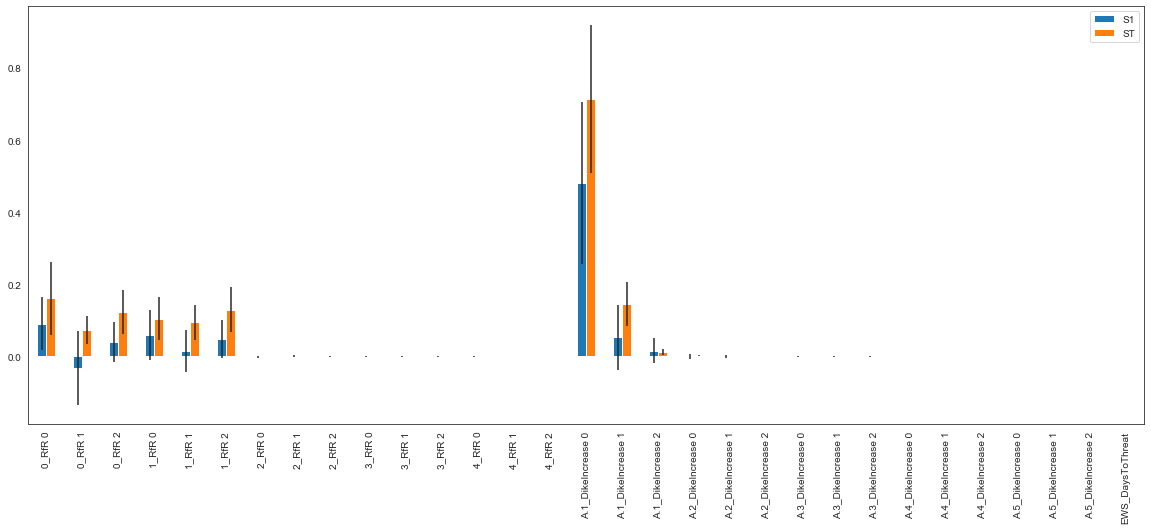

In [12]:
# Calculate the scores for the outcome "Gelderland Expected Annual Damage"
Si = sobol.analyze(problem, outcomes['Gelderland Expected Annual Damage'],
                   calc_second_order=True, print_to_console=False)

Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])


# Plot the related scores
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(20,10)
fig.subplots_adjust(bottom=0.3)
plt.show()

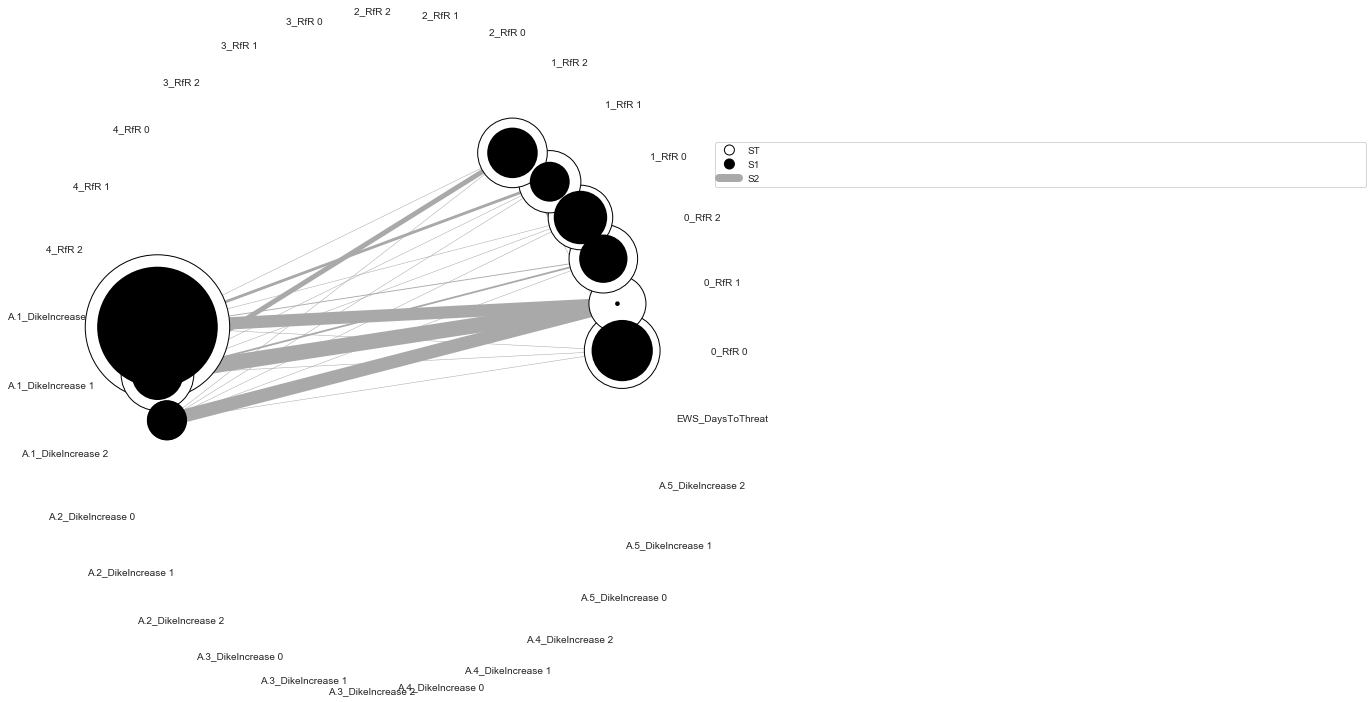

In [13]:
figi = plot_sobol_indices(Si, problem, criterion='ST', threshold=0.005)
figi.set_size_inches(12,12)
figi.axes.append(fig)

plt.show()

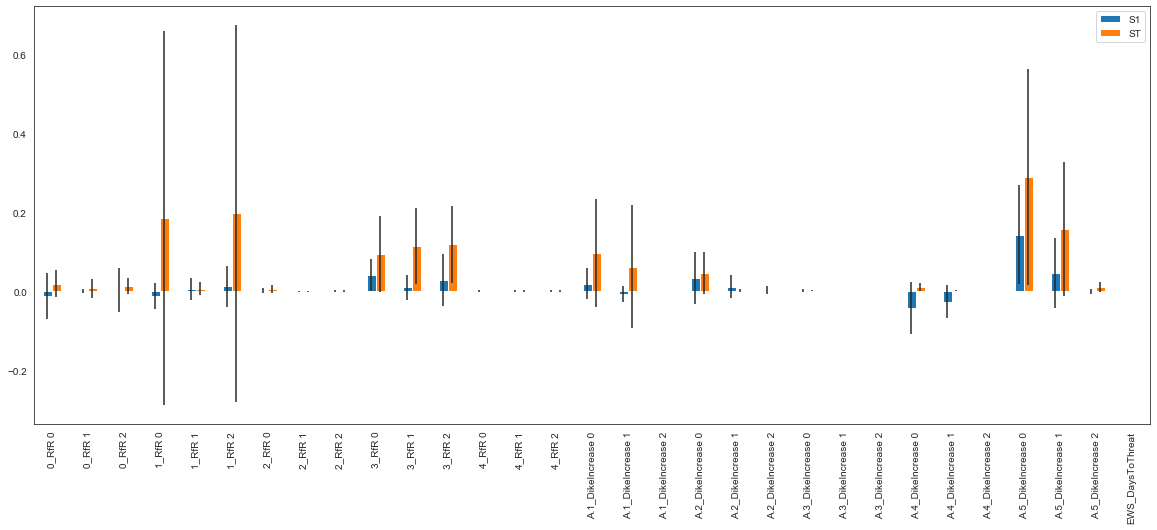

In [14]:
# Calculate the scores for the outcome "Overijssel Expected Annual Damage"
Si = sobol.analyze(problem, outcomes['Overijssel Expected Annual Damage'],
                   calc_second_order=True, print_to_console=False)

Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

# Plot the related scores
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(20,10)
fig.subplots_adjust(bottom=0.3)
plt.show()

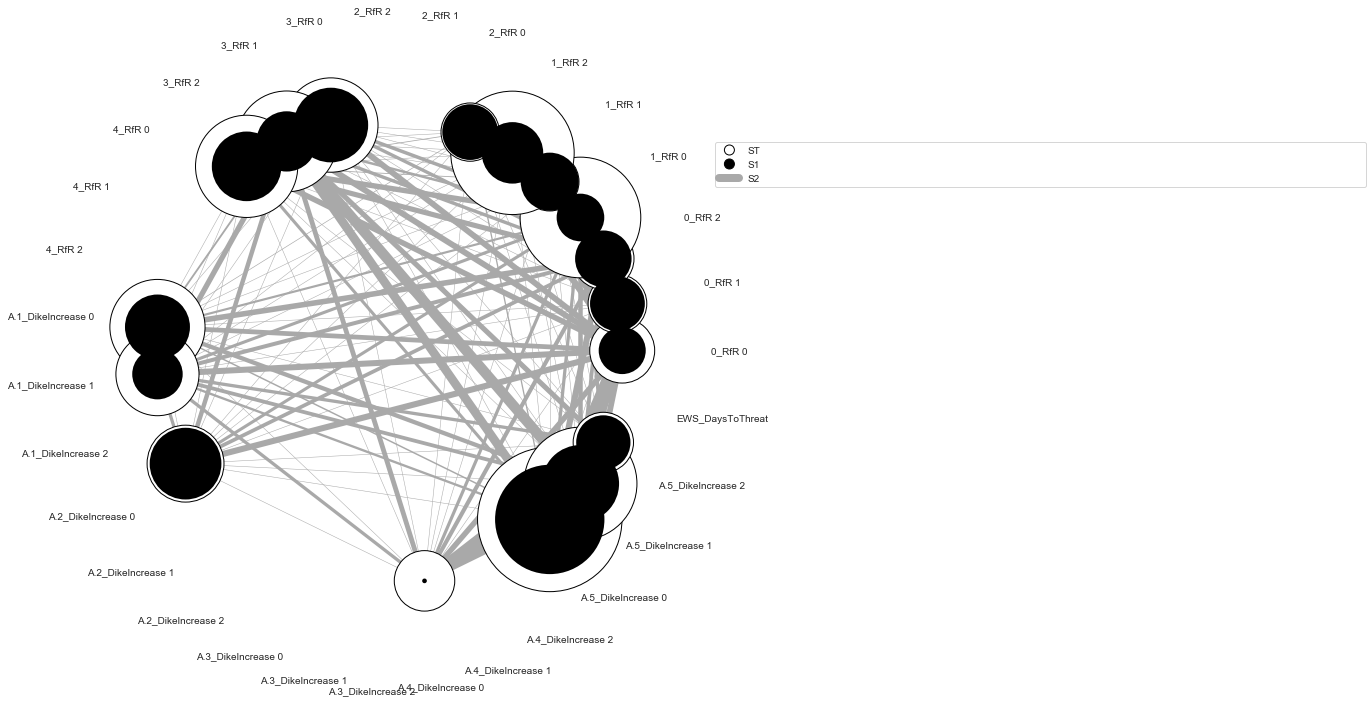

In [15]:
figi = plot_sobol_indices(Si, problem, criterion='ST', threshold=0.005)
figi.set_size_inches(12,12)
figi.axes.append(fig)

plt.show()

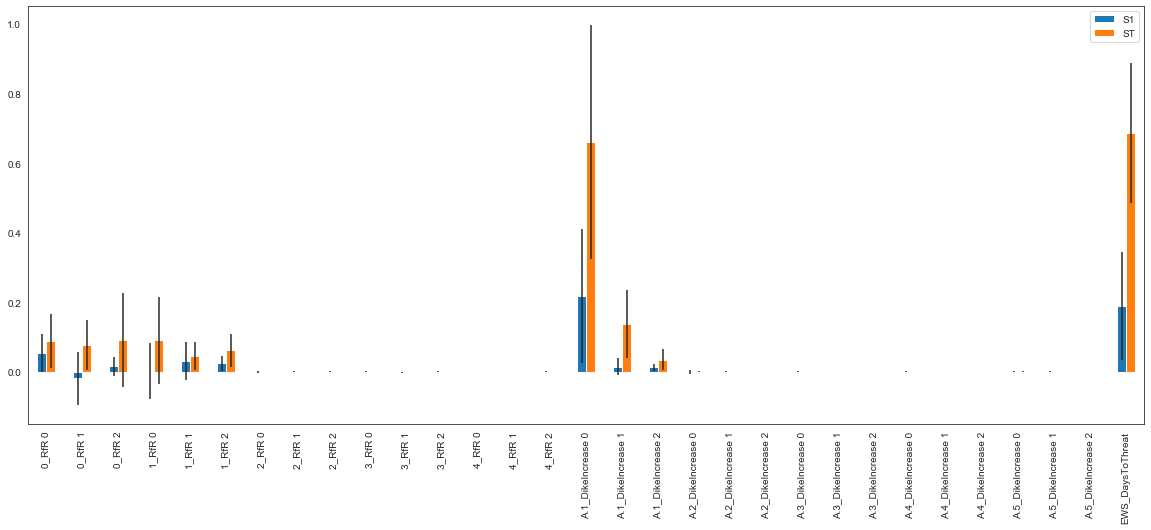

In [16]:
# Calculate the scores for the outcome "Expected Number of Deaths"
Si = sobol.analyze(problem, outcomes['Expected Number of Deaths'],
                   calc_second_order=True, print_to_console=False)

Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

# Plot the related scores
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(20,10)
fig.subplots_adjust(bottom=0.3)
plt.show()

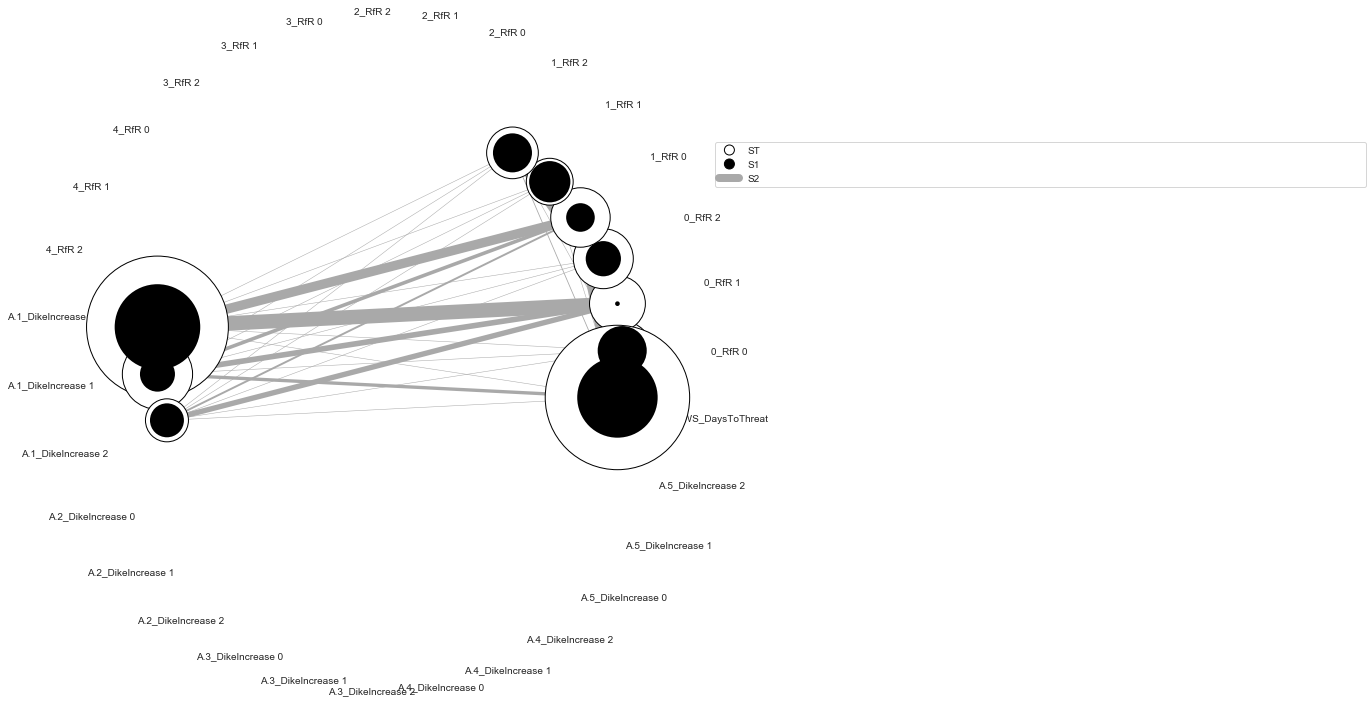

In [17]:
figi = plot_sobol_indices(Si, problem, criterion='ST', threshold=0.005)
figi.set_size_inches(12,12)
figi.axes.append(fig)

plt.show()

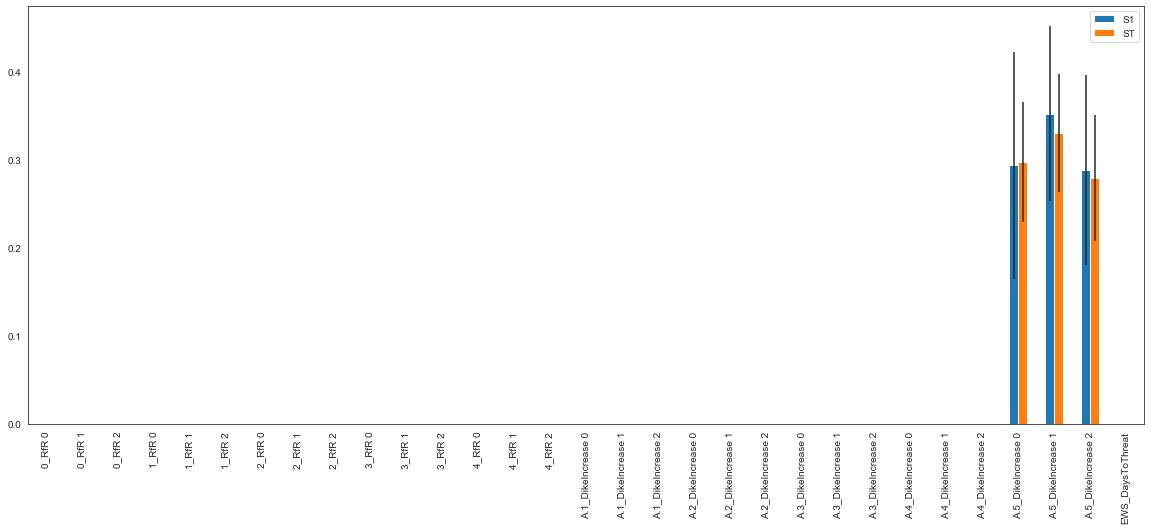

In [18]:
# Calculate the scores for the outcome "Overijssel Dike Cost"
Si = sobol.analyze(problem, outcomes['Overijssel Dike Cost'],
                   calc_second_order=True, print_to_console=False)

Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])


# Plot the related scores
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(20,10)
fig.subplots_adjust(bottom=0.3)
plt.show()

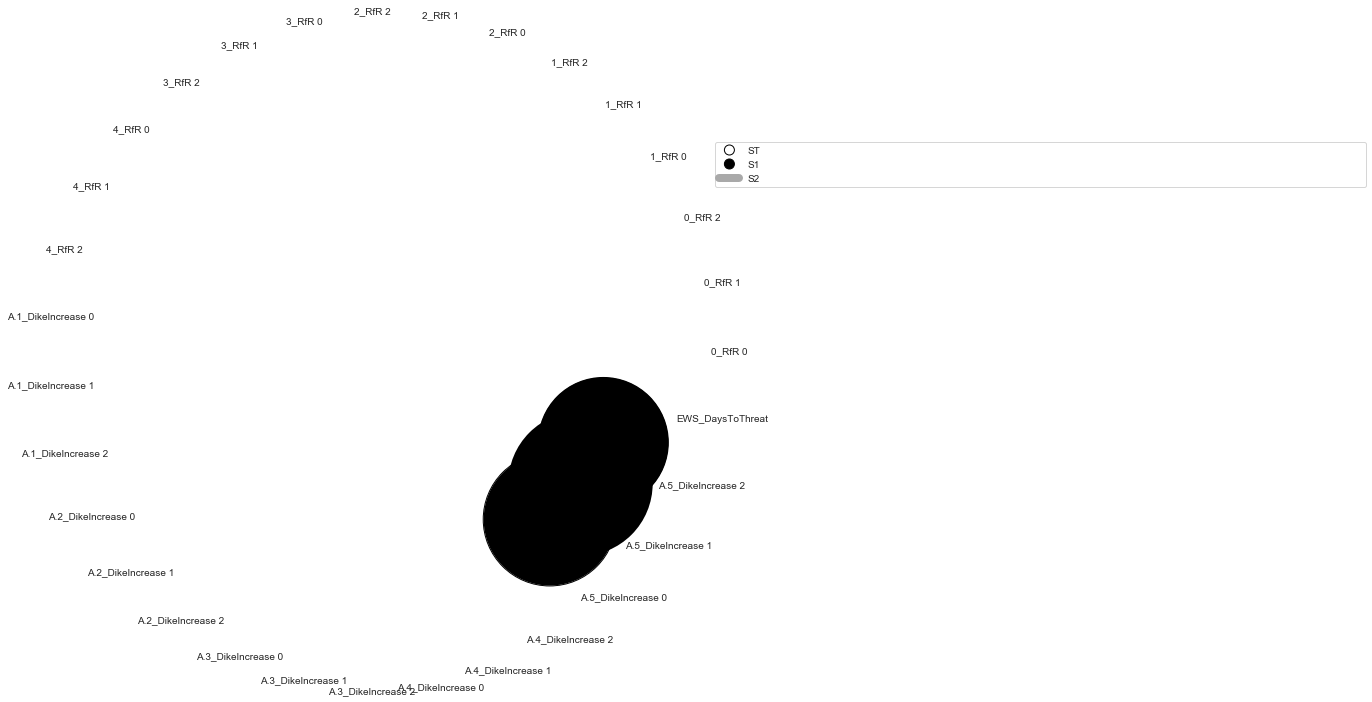

In [19]:
figi = plot_sobol_indices(Si, problem, criterion='ST', threshold=0.005)
figi.set_size_inches(12,12)
figi.axes.append(fig)

plt.show()

Gelderland Dike Cost

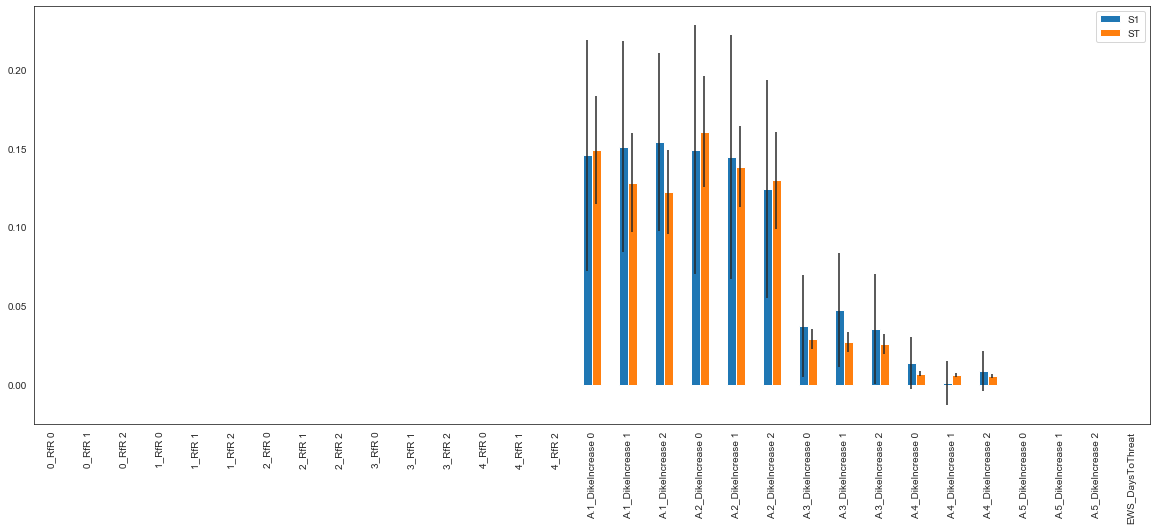

In [30]:
# Calculate the scores for the outcome "Gelderland Dike Cost"
Si = sobol.analyze(problem, outcomes['Gelderland Dike Cost'],
                   calc_second_order=True, print_to_console=False)

Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])


# Plot the related scores
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(20,10)
fig.subplots_adjust(bottom=0.3)
plt.show()

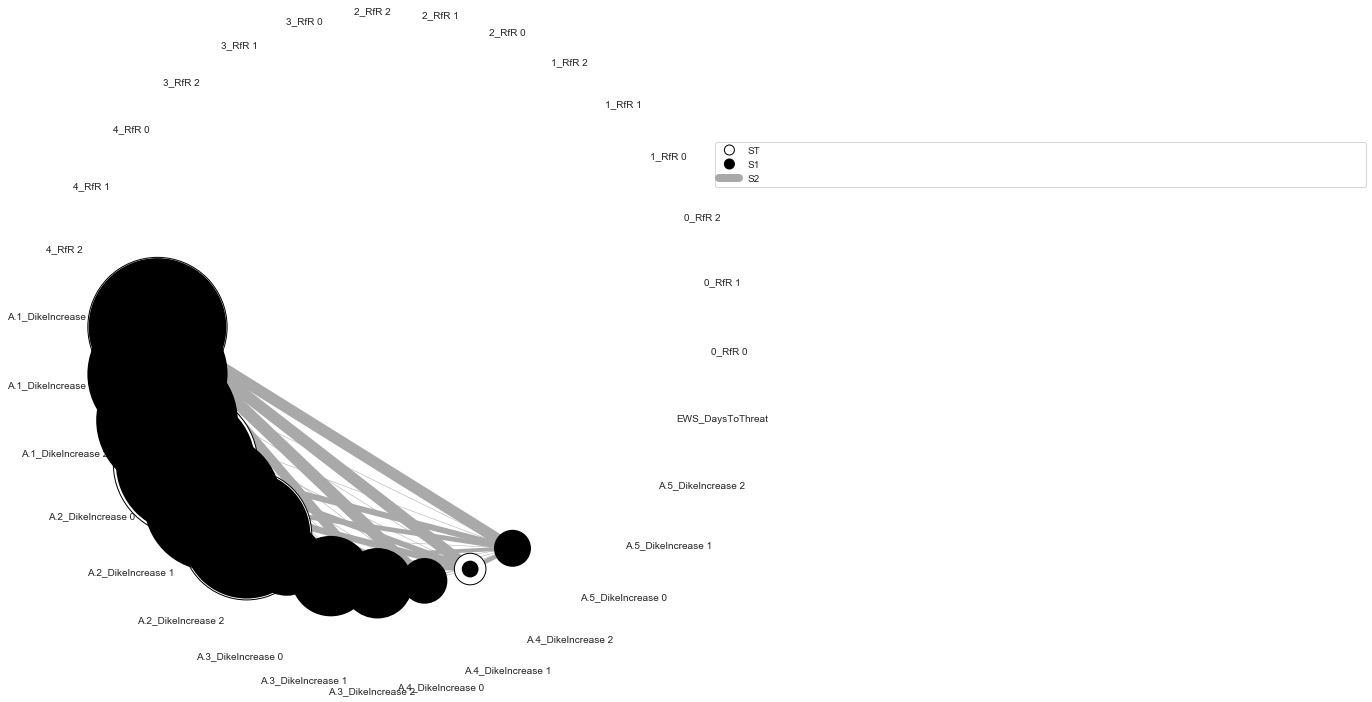

In [31]:
figi = plot_sobol_indices(Si, problem, criterion='ST', threshold=0.005)
figi.set_size_inches(12,12)
figi.axes.append(fig)

plt.show()

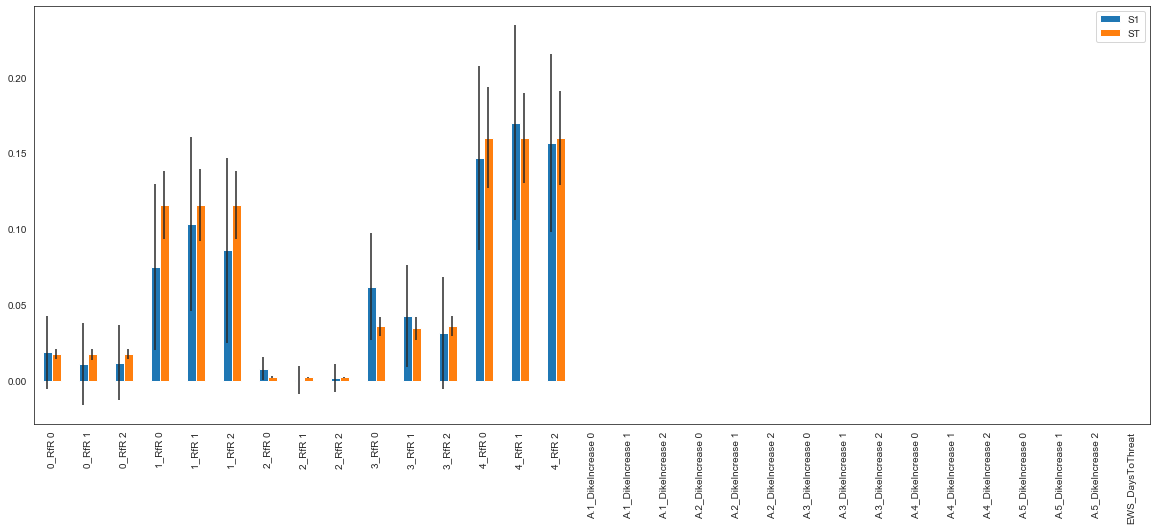

In [20]:
# Calculate the scores for the outcome "Room for River Investment Costs"
Si = sobol.analyze(problem, outcomes['Room for River Investment Costs'],
                   calc_second_order=True, print_to_console=False)

Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])


# Plot the related scores
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(20,10)
fig.subplots_adjust(bottom=0.3)
plt.show()

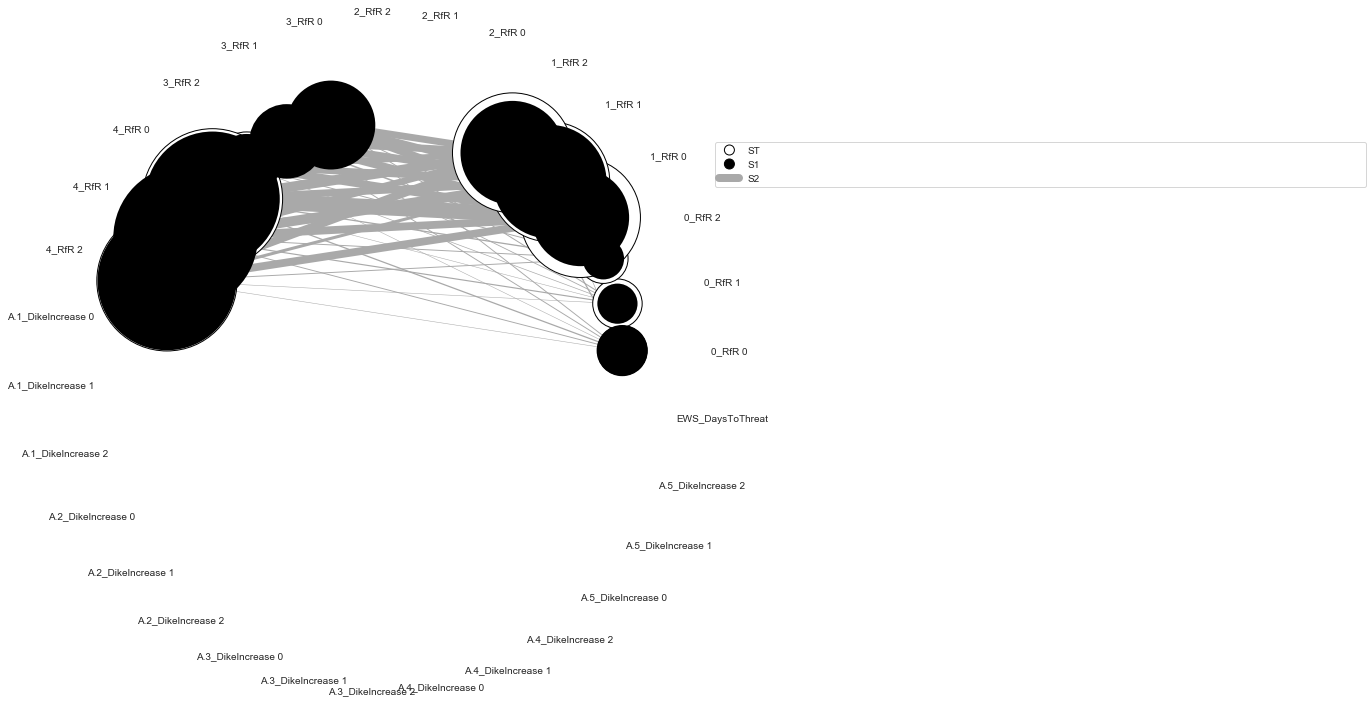

In [21]:
figi = plot_sobol_indices(Si, problem, criterion='ST', threshold=0.005)
figi.set_size_inches(12,12)
figi.axes.append(fig)

plt.show()

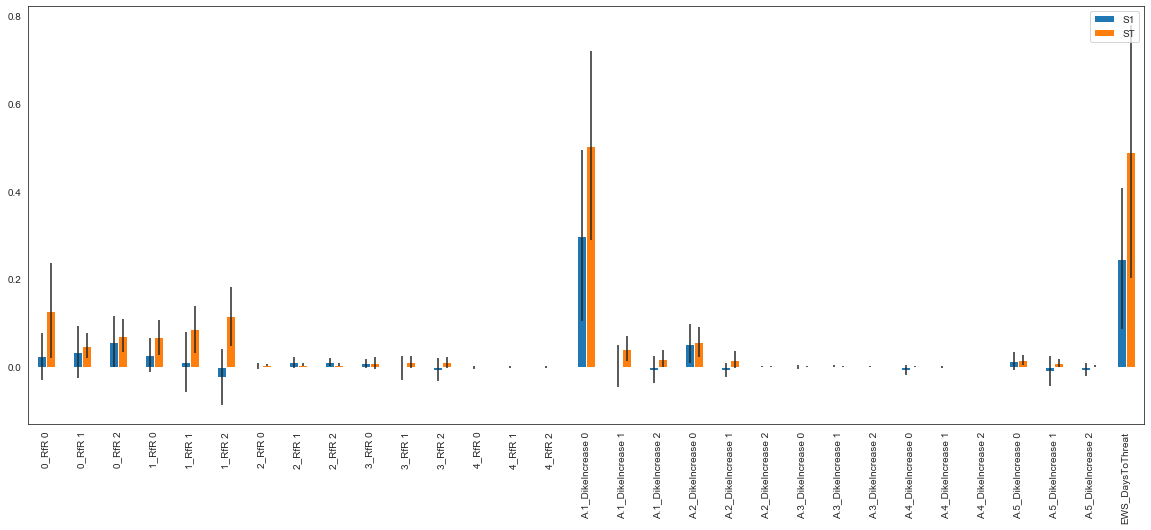

In [32]:
# Calculate the scores for the outcome "Evacuation Costs"
Si = sobol.analyze(problem, outcomes['Evacuation Costs'],
                   calc_second_order=True, print_to_console=False)

Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])


# Plot the related scores
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(20,10)
fig.subplots_adjust(bottom=0.3)
plt.show()

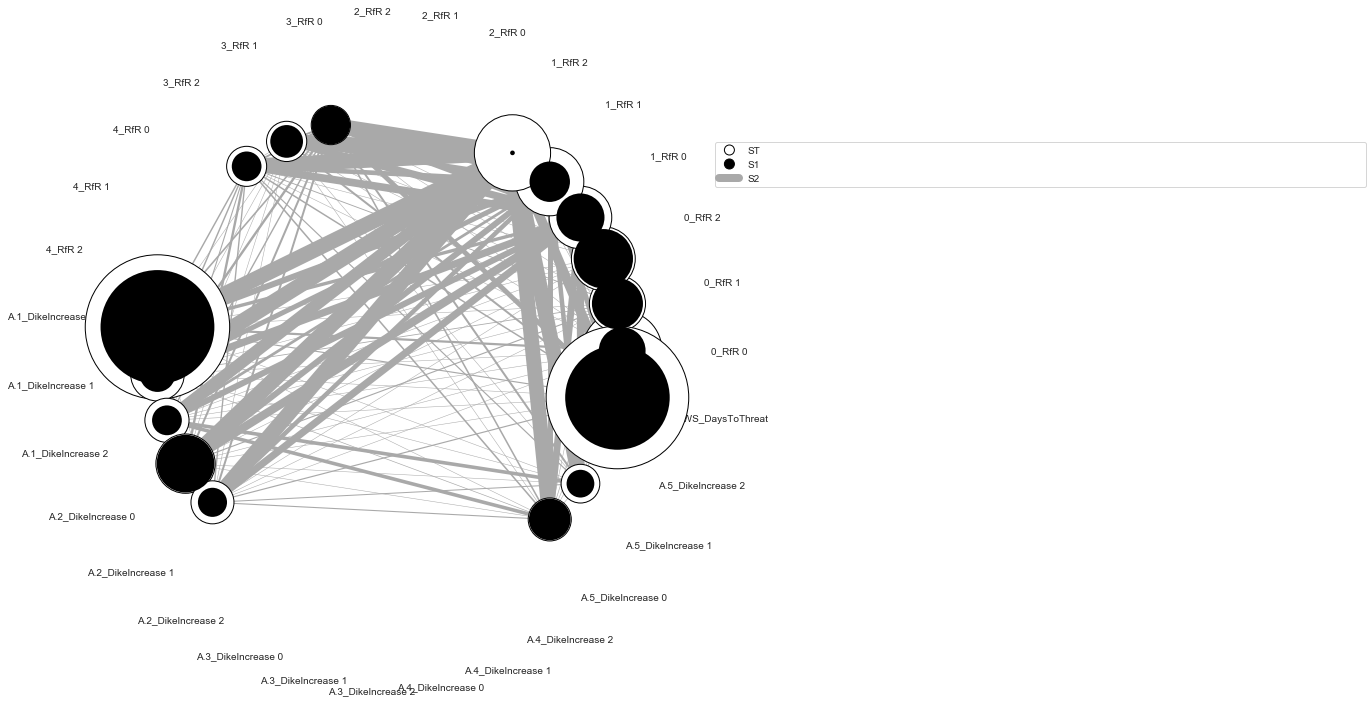

In [33]:
figi = plot_sobol_indices(Si, problem, criterion='ST', threshold=0.005)
figi.set_size_inches(12,12)
figi.axes.append(fig)

plt.show()

## 5.3 OLS Regression

In [40]:
# Execution of OLS Regression over levers
start = time.time()
results_lhs = perform_experiments(dike_model, scenarios=reference_scenario,
                                  policies=1000,
                                  levers_sampling=LHS)
end = time.time()
print('OLS Regression time is ' + str(round((end - start)/60)) + ' minutes')

exp_lhs, out_lhs = results_lhs

[MainProcess/INFO] performing 1 scenarios * 1000 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


OLS Regression time is 62 minutes


In [41]:
# Determination of mean and standard deviation for the outcome "Expected Annual Damage"
g_damage_lhs = out_lhs['Overijssel Expected Annual Damage']
g_damage_mean_lhs = np.mean(out_lhs['Overijssel Expected Annual Damage'])
g_damage_std_lhs = np.std(out_lhs['Overijssel Expected Annual Damage'])

# Fitting the OLS Regression model, when the outcome is considered to be "Expected Annual Damage"
X = pd.DataFrame(exp_lhs).drop(['model','policy','scenario'], inplace=False, axis=1)
X_0 = sm.add_constant(X)

est = sm.OLS(g_damage_lhs, X_0.astype(float)).fit()
print(est.summary())
print(est.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     11.88
Date:                Fri, 19 Jun 2020   Prob (F-statistic):           4.55e-49
Time:                        10:26:32   Log-Likelihood:                -18112.
No. Observations:                1000   AIC:                         3.629e+04
Df Residuals:                     968   BIC:                         3.644e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
discount rate 0         -9

In [42]:
# Determination of mean and standard deviation for the outcome "Expected Annual Damage"
g_damage_lhs = out_lhs['Evacuation Costs']
g_damage_mean_lhs = np.mean(out_lhs['Evacuation Costs'])
g_damage_std_lhs = np.std(out_lhs['Evacuation Costs'])

# Fitting the OLS Regression model, when the outcome is considered to be "Expected Annual Damage"
X = pd.DataFrame(exp_lhs).drop(['model','policy','scenario'], inplace=False, axis=1)
X_0 = sm.add_constant(X)

est = sm.OLS(g_damage_lhs, X_0.astype(float)).fit()
print(est.summary())
print(est.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     36.41
Date:                Fri, 19 Jun 2020   Prob (F-statistic):          1.47e-139
Time:                        10:26:38   Log-Likelihood:                -9853.1
No. Observations:                1000   AIC:                         1.977e+04
Df Residuals:                     968   BIC:                         1.993e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
discount rate 0         -1